In [1]:
import gc
from PIL import Image
import requests
from transformers import AutoTokenizer, AutoProcessor, LlavaForConditionalGeneration, Blip2Model, Blip2Processor, Blip2ForConditionalGeneration, Blip2Config
import time
import torch
from torch.nn import functional as F
from torch.nn import CrossEntropyLoss
from typing import Any, Optional, Tuple, Union
from transformers import TrainingArguments
import numpy as np
import evaluate
import wandb

from dataclasses import dataclass
import pandas as pd
from transformers import GPT2TokenizerFast

device = "cuda" if torch.cuda.is_available() else "cpu"

# Download Weights

In [2]:
processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", load_in_8bit=True, device_map={"": 0}, torch_dtype=torch.float16)
reference_model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", load_in_8bit=True, device_map={"": 0}, torch_dtype=torch.float16)
print(f'Memory Allocated after instantiating models: {torch.cuda.memory_allocated(0)/1e9:.4g} GB')

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Memory Allocated after instantiating models: 8.001 GB


## Hyperparameters

In [3]:
training_args = TrainingArguments(
    output_dir='./test_trainer',     # output directory
    num_train_epochs=2,              # total # of training epochs
    per_device_train_batch_size=5,   # batch size per device during training
    per_device_eval_batch_size=5,    # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
)

wandb.init(
    # set the wandb project where this run will be logged
    project="coffee-bot",
    
    # track hyperparameters and run metadata
    config={
        "learning_rate": 3e-4,
        "architecture": model.__class__.__name__,
        "dataset": "ROASTME-9540",
        "num_train_epoch": training_args.num_train_epochs,
        "warmup_steps": training_args.warmup_steps,
        "weight_decay": training_args.weight_decay,
        "per_device_train_batch_size": training_args.per_device_train_batch_size,
        "per_device_eval_batch_size": training_args.per_device_eval_batch_size,        
    }
)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, eps=10e-4)

wandb: Currently logged in as: devonperoutky. Use `wandb login --relogin` to force relogin


# Fine Tune

## Read In Dataset

In [4]:
filename = '../datasets/full_ds.csv'
df = pd.read_csv(filename)
df.head()

submission_id comment_id                                            comment  \
0        amnyr9    efnhj58  Sometimes the line between life and suicide is...   
1        amnyr9    efngbk8  Your support is amazing, I feel like I can act...   
2        amnyr9    efnhf5p  As a Russian are you obligated to dress as the...   
3        amnyr9    efngwcp  You're a perfectly valid person and we care ab...   
4        amnyr9    efngp00   I had the same haircut once, I was about 1s old    

   width  height                            image_url           image_path  
0   1960    4032  https://i.redd.it/s2fi2wr7ibe21.jpg  ./images/amnyr9.jpg  
1   1960    4032  https://i.redd.it/s2fi2wr7ibe21.jpg  ./images/amnyr9.jpg  
2   1960    4032  https://i.redd.it/s2fi2wr7ibe21.jpg  ./images/amnyr9.jpg  
3   1960    4032  https://i.redd.it/s2fi2wr7ibe21.jpg  ./images/amnyr9.jpg  
4   1960    4032  https://i.redd.it/s2fi2wr7ibe21.jpg  ./images/amnyr9.jpg

## Training Loop

In [ ]:
# Prepare model for training
model.train()

# Dataset variables
prompt = "Question: How would you describe this person? Answer:"
labels = []
image = None
submission_id = None
out = None
losses = []


with torch.autograd.detect_anomaly():
    for epoch in range(training_args.num_train_epochs):
        print(f'EPOCH #{epoch}')
        for index, row in df.iterrows():    
            comment = row['comment']
            image_url = row['image_url']
            
            if submission_id is None:
                submission_id = row['submission_id']
        
            if image is None:
                image = Image.open(requests.get(image_url, stream=True).raw)
        
            # We reached a new submission
            if row['submission_id'] != submission_id or len(labels) >= training_args.per_device_train_batch_size:        
                # Expand the inputs
                prompts = [prompt] * len(labels)
                image_inputs = [image] * len(labels)
    
                try:
                    
                    # Forward Pass 
                    print(f'Forward pass {len(prompts)} prompts and {len(labels)} labels ({row["submission_id"]})')
                    label_input_ids = processor.tokenizer(labels, return_tensors="pt", padding=True, max_length=256, truncation=True).input_ids
                    inputs = processor(image_inputs, prompts, return_tensors="pt", padding=True, max_length=256, truncation=True).to(0, torch.float16)
                
                    out = model(pixel_values=inputs.pixel_values, input_ids=inputs.input_ids, attention_mask=inputs.attention_mask, labels=label_input_ids)
                    print(out.loss)
        
                    # Backprop (calculate gradients)
                    out.loss.backward()
        
                    # Update weights using gradients
                    optimizer.step()
                    
                    # Reset the gradients
                    optimizer.zero_grad()
                    print(f"Loss at step {index} = {out.loss.item()}")
    
                    losses.append(out.loss.item())
                    print(f'Memory Allocated after first pass : {torch.cuda.memory_allocated(0)/1e9:.4g} GB')
                    print("--------------")

                    run_inference(reference_model, inputs, 'Reference')
                    model.eval()
                    run_inference(model, inputs, 'Fine-tuned Model')
                    
                    # Reset
                    submission_id = row['submission_id']
                    image = Image.open(requests.get(row['image_url'], stream=True).raw)
                    labels = [row['comment']]
                    break
                except ValueError as ve:
                    # Code to handle the ValueError
                    print(f"Error: {ve}")
                    print(f"INPUTS: {prompts}")
                    print(f"LABELS: {labels}")
                    break
            else:
                labels.append(comment)

# fine_tuned_model = model.load_state_dict(torch.load('./fine_tuned_model_state_dict.pth'))
# fine_tuned_model = Blip2ForConditionalGeneration.from_pretrained("./fine_tuned_model", load_in_8bit=True, device_map={"": 0}, torch_dtype=torch.float16)

## Save Checkpoint

In [ ]:
torch.save(model.state_dict(), './fine_tuned_model_state_dict.pth')

In [ ]:
model.save_pretrained("./fine_tuned_model", from_pt=True) 

# Test

In [19]:
def run_inference(model, inputs):
    # print(inputs)
    generated_ids = model.generate(**inputs)
    print(generated_ids)
    print(processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip())


def run_inference_on_row(index):
    row = df.iloc[index]
    label = row['comment']
    prompt = 'Question: How would you insult this person? Answer:'
    image_url = row['image_url']
    image = Image.open(requests.get(image_url, stream=True).raw)

    display(image)
    inputs = processor(images=image, text=prompt, return_tensors="pt", padding=True, max_length=256, truncation=True).to(device, torch.float16)

    ids = reference_model.generate(**inputs)
    print(f'REFERENCE: {processor.batch_decode(ids, skip_special_tokens=True)[0].strip()}')
    print(f'LABEL: {label}')

    generated_ids = model.generate(**inputs)
    return processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()

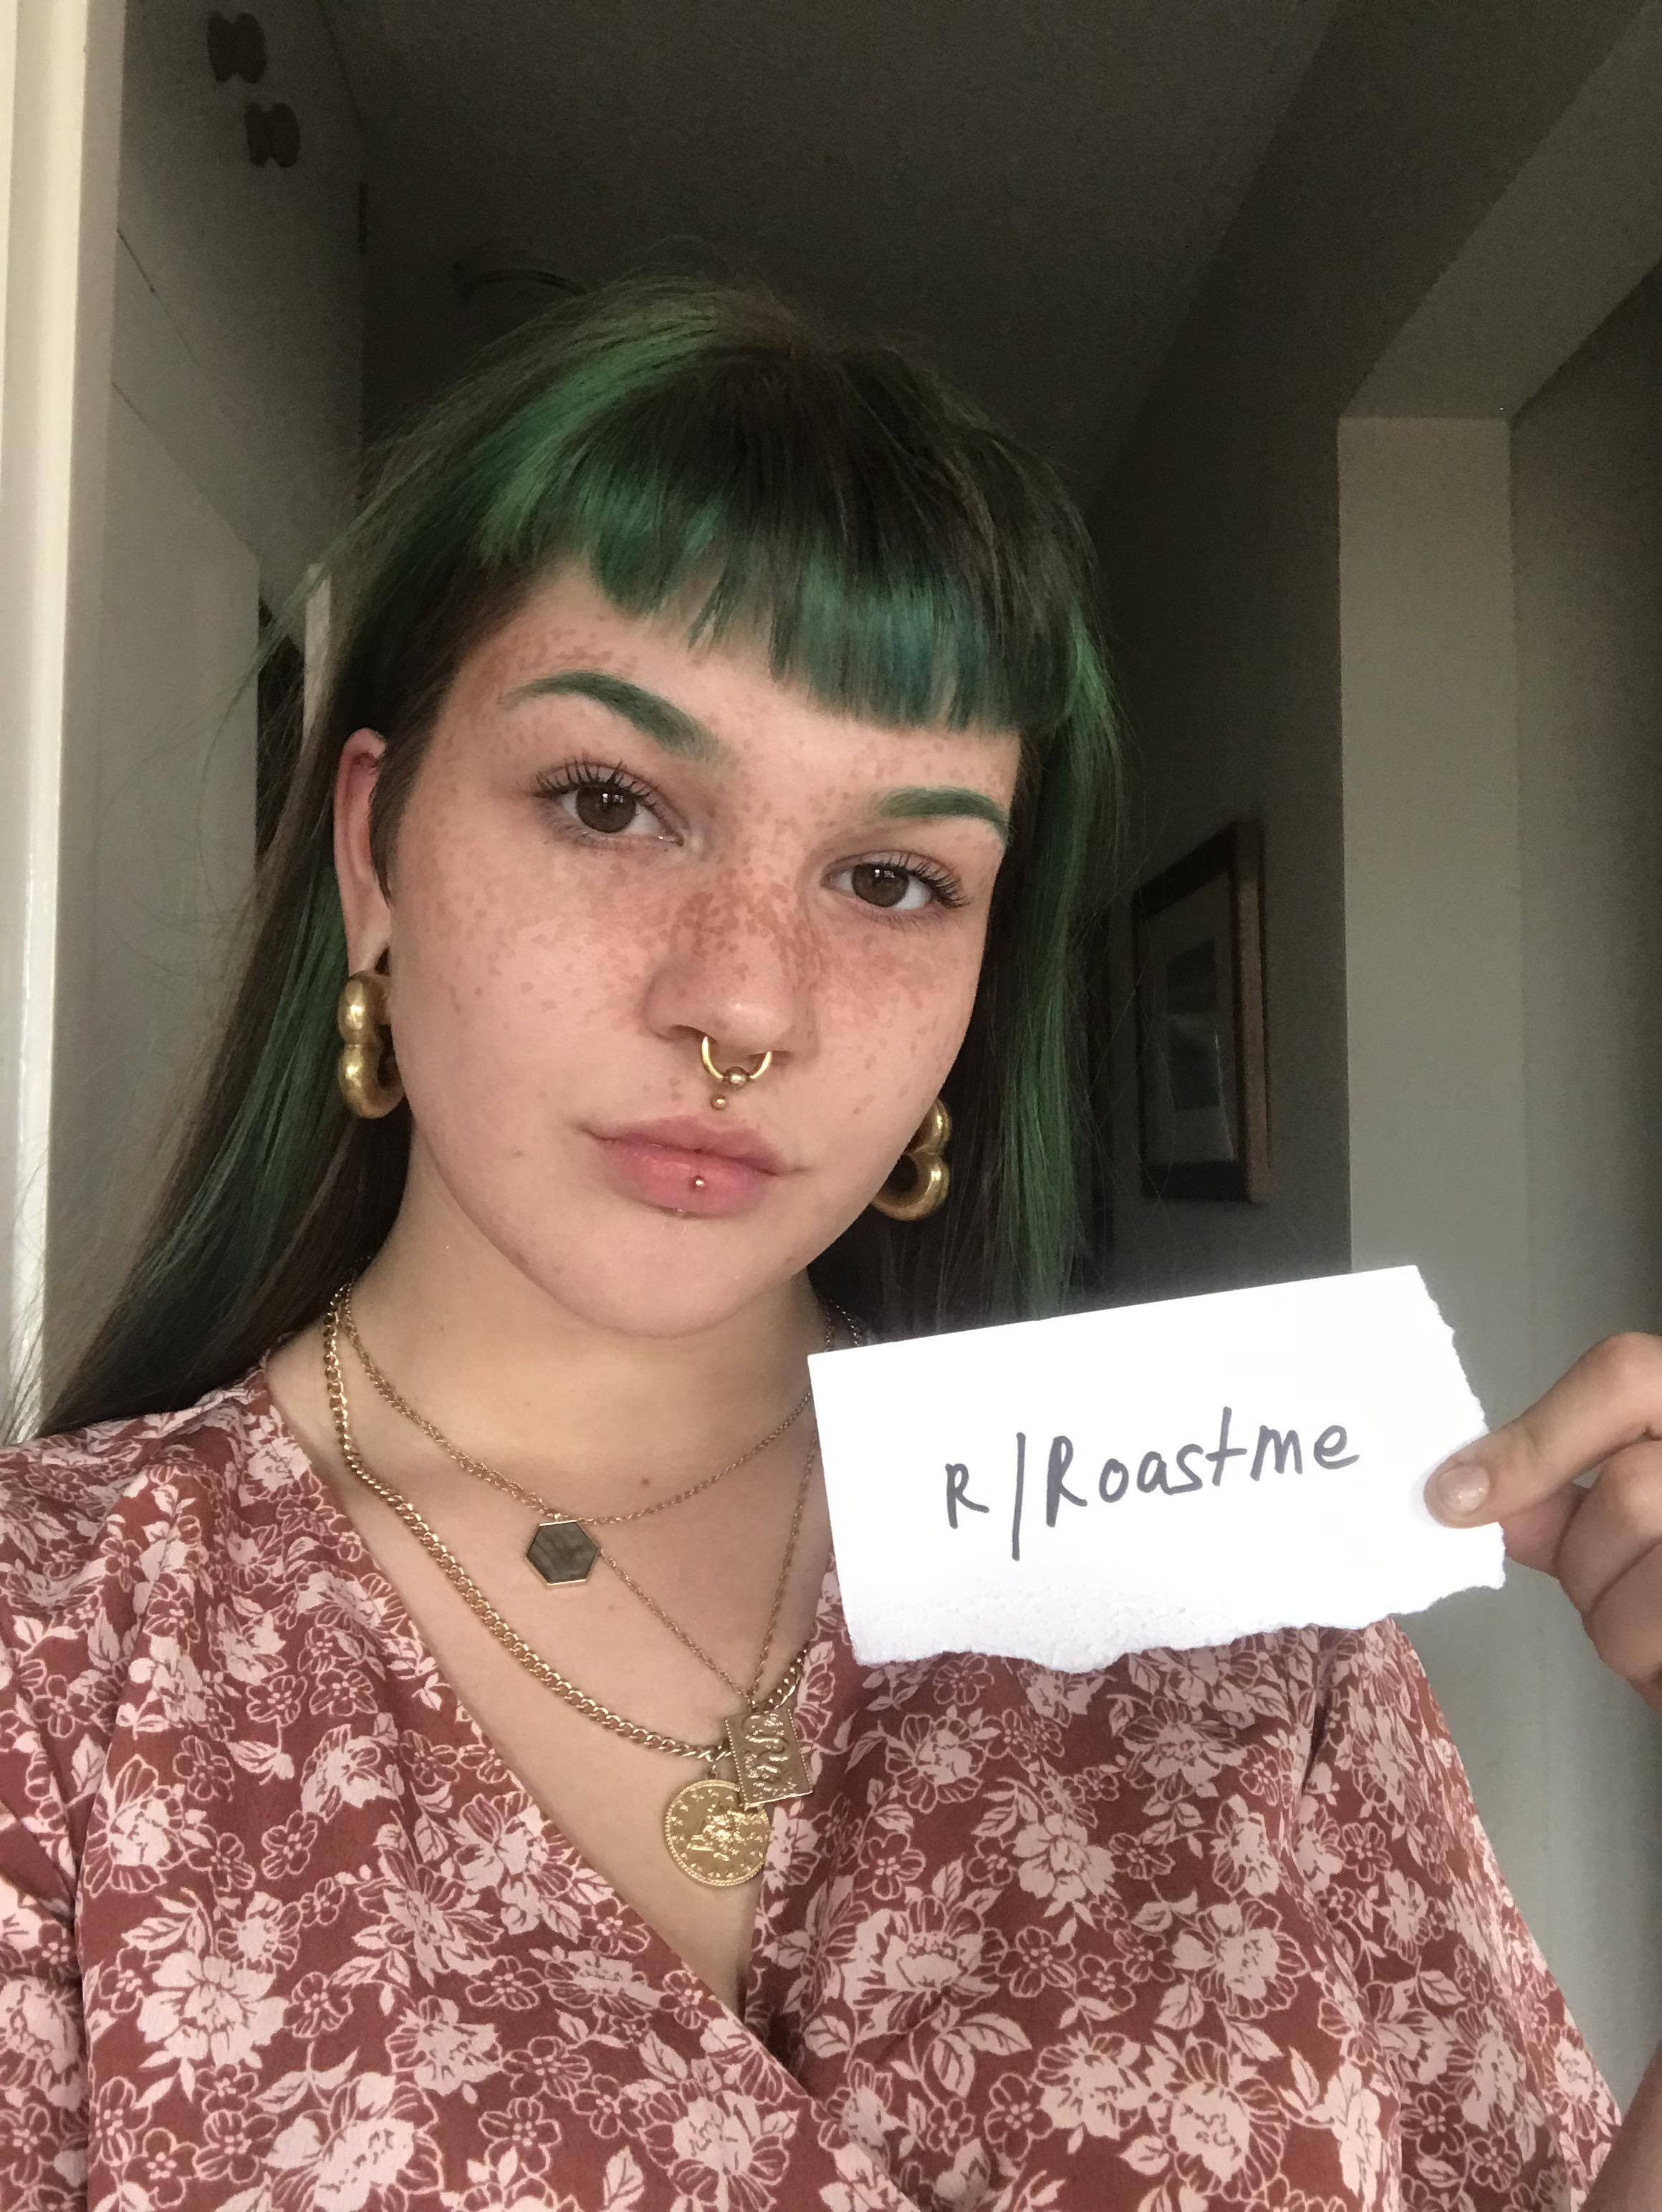

REFERENCE: "i'm a f**king idiot"
LABEL: You look like an elven STD


'"i\'m a f**king idiot"'

In [20]:
run_inference_on_row(2010)

In [ ]:
prompt = "Question: How would you describe this person? Answer:"
url = "https://i.redd.it/0o673i8z5bkb1.jpg"
label = "I failed a drug test just by looking at this picture."
image = Image.open(requests.get(url, stream=True).raw)
display(image)

In [ ]:
# Prepare Inputs
label_input_ids = processor.tokenizer(label, return_tensors="pt", padding=True, max_length=256, truncation=True).input_ids
inputs = processor(images=image, text=prompt, return_tensors="pt", padding=True, max_length=256, truncation=True).to(device, torch.float16)

# [REFERENCE] Simple Forward pass
ids = reference_model.generate(**inputs)
print(processor.batch_decode(ids, skip_special_tokens=True)[0].strip())

# [MODEL] Simple Forward pass
ids = model.generate(**inputs)
print(processor.batch_decode(ids, skip_special_tokens=True)[0].strip())

In [ ]:
# Forward + Backwards prop
out = model(pixel_values=inputs.pixel_values, input_ids=inputs.input_ids, attention_mask=inputs.attention_mask, labels=label_input_ids)
print(out.loss)
        
# Backprop (calculate gradients)
out.loss.backward()

# Update weights using gradients
optimizer.step()

# Reset the gradients
optimizer.zero_grad()

In [ ]:
# [REFERENCE] Simple Forward pass
ids = reference_model.generate(**inputs)
print(processor.batch_decode(ids, skip_special_tokens=True)[0].strip())

# [Fine Tune MODEL] Simple Forward pass
ids = model.generate(**inputs)
print(processor.batch_decode(ids, skip_special_tokens=True)[0].strip())